In [1]:
###Imports###
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
from matplotlib import colors
import random
import statistics
import math
from scipy.stats import t

In [2]:

# How many board layouts are possible in the simplest game?
def calculate_combinations(board_len, ships):
    tiles = board_len ** 2
    combinations = math.factorial(tiles) / math.factorial(tiles - ships)
    return combinations

# Convert a linear index ship position to row and column
def convert_ship_index(index, board_len):
    row = math.floor(index / board_len)
    col = index % board_len
    return [row, col]

# Simple game turn-taking
def simple_turn(guess_board, board, player_lives):
    # Player can only guess where there is no ship or previous shot
    valid_targets = np.where(guess_board==0)
 
    #Convert the valid_targets to a 1D ordered array for random selection
    valid_targets_actual = np.ravel_multi_index(valid_targets, np.shape(guess_board))
    #print('valid targets', valid_targets_actual)

    # Initialize a numpy Generator object
    rng = np.random.default_rng()

    # Take a shot
    shot = rng.choice(valid_targets_actual, size=1, shuffle=False)
    #print('shot', shot)

    shot_actual = np.unravel_index(shot, np.shape(guess_board))
    #print('shot_actual', shot_actual)
    
    # Other player responds to guess
    check_hit = board[shot_actual]
    #print('check hit', check_hit)
    
    match check_hit:

        case 0:
            #print("Player missed at", shot_actual)
            guess_board[shot_actual] = 2
            board[shot_actual] = 2

        case 1:
            #print("Player sunk a ship at", shot_actual)
            guess_board[shot_actual] = 4
            board[shot_actual] = 4
            player_lives -= 1
    
    return guess_board, board, player_lives

# Single board plotting function
def plot_board(ax, board, cmap, norm, title):

    # Plot the basic board with colored squares
    ax.imshow(board, cmap=cmap, norm=norm)

    # Set the title of the plot
    ax.set_title(title)

    # Infer size of board
    board_size = board.shape[0]

    # Create a list of capital letters to use for vertical (row) labels
    row_labels = [chr(i) for i in range(65, 65 + board_size)]

    # Create a list of integers to use for horizontal (column) labels
    col_labels = [i for i in range(1, board_size + 1)]

    # Add a grid to the plot
    ax.grid(which='major', axis='both', linestyle='-', color='white', linewidth=2)
    ax.set_xticks(np.arange(-0.5, board_size-1, 1))
    ax.set_yticks(np.arange(-0.5, board_size-1, 1))

    # Label rows with letters and columns with numbers
    ax.set_yticklabels(row_labels)
    ax.set_xticklabels(col_labels)
    
    return ax

# Function to plot all 4 boards together
def plot_all_boards(board1, board2, guess_board1, guess_board2):

    #Fixed colormap
    cmap = colors.ListedColormap(['lightblue', 'green', 'yellow', 'red', 'black'])

    #0.5-off gridlines to make filled squares plot
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    #Explain the color of each cell
    legend = ['Empty', 'Ship', 'Miss', 'Hit', 'Sunk']

    # On-integer indexes for ticks
    tick_idx = np.arange(len(legend))

    # Create the figure and axs objects
    fig, axs = plt.subplots(2, 2)

    # Plot all four boards
    axs[0, 0] = plot_board(axs[0, 0], guess_board1, cmap, norm, "Player 1's Guess")
    axs[0, 1] = plot_board(axs[0, 1], guess_board2, cmap, norm, "Player 2's Guess")
    axs[1, 0] = plot_board(axs[1, 0], board1, cmap, norm, "Player 1's Fleet")
    axs[1, 1] = plot_board(axs[1, 1], board2, cmap, norm, "Player 2's Fleet")

    # Create colored dummy rectangles for legend
    handles = [plt.Rectangle((0, 0), 0, 0, color=cmap(i), label=legend[i]) for i in tick_idx]

    # Show the legend in the center of all 4 subplots
    fig.legend(handles=handles, loc='center')

    plt.tight_layout()
    plt.show()

    return fig, axs
### Simplest game - n single-space ships hidden on an m by m grid ###

board_size = 10
fleet = ['Battleship', 'Cruiser', 'Destroyer', 'Submarine', 'Patrol Boat']
fleet_shapes = [1, 1, 1, 1, 1]
fleet_size = len(fleet)

#Print Fleet info
print('Fleet:', fleet)
print('There are ', fleet_size, 'ships in the fleet,')
print('of  lengths', fleet_shapes, '.')
print('The board is a square with length', board_size, '.')

#How many boards are possible?
combos = calculate_combinations(board_size, fleet_size)
print('In the simplest game of Battleship, each player has', f"{combos:,}", 'possible boards.')
# Initialize both players' boards
board1 = np.zeros((board_size, board_size))
board2 = np.zeros((board_size, board_size))

# Generate a random starting position for each player's fleet

# Initialize a numpy Generator object
rng = np.random.default_rng()

# How many tiles are in each board?
tiles = board_size * board_size

#Generate fleet positions from all possible tiles for each board
fleet_positions1 = rng.choice(tiles, size=fleet_size, replace=False, shuffle=False)
fleet_positions2 = rng.choice(tiles, size=fleet_size, replace=False, shuffle=False)

# Convert fleet positions to a 2D array of rows and columns
fleet1_actual = np.unravel_index(fleet_positions1, (board_size, board_size))
fleet2_actual = np.unravel_index(fleet_positions2, (board_size, board_size))

# Place each player's fleet on their respective boards by setting the coordinates (matrix locations) where ships are placed to 1
board1[fleet1_actual] = 1
board2[fleet2_actual] = 1

# Generate each player's 'view' of the opponent's board. Initially blank!
guess_board1 = np.zeros((board_size, board_size))
guess_board2 = np.zeros((board_size, board_size))

Fleet: ['Battleship', 'Cruiser', 'Destroyer', 'Submarine', 'Patrol Boat']
There are  5 ships in the fleet,
of  lengths [1, 1, 1, 1, 1] .
The board is a square with length 10 .
In the simplest game of Battleship, each player has 9,034,502,400.0 possible boards.


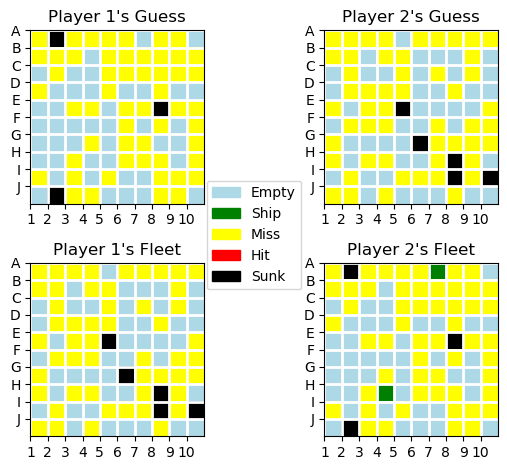

Player 2 wins!


In [7]:
### Simple Game Loop ###
from IPython.display import clear_output

# Get current date and time to make a unique filepath
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Create a directory to store the figure images from the timestamp
output_dir = os.path.join("output", timestamp)
os.makedirs(output_dir, exist_ok=True)

# Show the initial gamestate
fig, axs = plot_all_boards(board1, board2, guess_board1, guess_board2)
plt.savefig(os.path.join(output_dir, "frame_0.png"))  # Save the initial figure as an image

# Show the initial gamestate
fig, axs = plot_all_boards(board1, board2, guess_board1, guess_board2)
plt.show()

player1_live = fleet_size
player2_live = fleet_size

# Main loop
frame = 0

while player1_live > 0 and player2_live > 0:
    # Player 1's turn
    guess_board1, board2, player2_live = simple_turn(guess_board1, board2, player2_live)

    # Player 2's turn
    guess_board2, board1, player1_live = simple_turn(guess_board2, board1, player1_live)

    # Update board plot
    clear_output(wait=True)
    fig, axs = plot_all_boards(board1, board2, guess_board1, guess_board2)

    # Frame number is incremented by 1 after each turn
    frame += 1

    # Make a string with the frame number to save the image
    fname = os.path.join(output_dir, "frame_" + str(frame) + ".png")

    #save the figure as an image
    fig.savefig(fname)

    plt.show()

if player1_live == 0:
    print("Player 2 wins!")
else:
    print("Player 1 wins!")


Mean turns: 84.151923
Median turns: 88.0
Standard deviation of turns: 13.801310042102159
95% Confidence Interval: (84.12487289663748, 84.17897310336251)


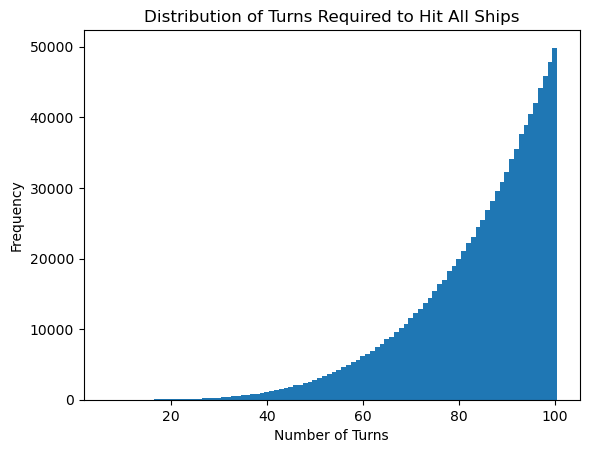

<Figure size 640x480 with 0 Axes>

In [19]:
### Monte Carlo simulation of SBS games ###
# Calculates the distribution of turns needed to complete games

num_games = 1000000
turns_required = []

for _ in range(num_games):
    tiles_remaining = list(range(100))
    ships = random.sample(tiles_remaining, 5)
    turns = 0

    while ships:
        turns += 1
        shot = random.choice(tiles_remaining)
        tiles_remaining.remove(shot)
        if shot in ships:
            ships.remove(shot)

    turns_required.append(turns)

mean_turns = statistics.mean(turns_required)
median_turns = statistics.median(turns_required)
std_dev_turns = statistics.stdev(turns_required)

confidence_level = 0.95
t_value = t.ppf((1 + confidence_level) / 2, num_games - 1)
margin_error = t_value * std_dev_turns / math.sqrt(num_games)
confidence_interval = (mean_turns - margin_error, mean_turns + margin_error)

print("Mean turns:", mean_turns)
print("Median turns:", median_turns)
print("Standard deviation of turns:", std_dev_turns)
print("95% Confidence Interval:", confidence_interval)

# Plotting the distribution
plt.hist(turns_required, bins=range(min(turns_required), max(turns_required) + 2), align='left')
plt.xlabel("Number of Turns")
plt.ylabel("Frequency")
plt.title("Distribution of Turns Required to Hit All Ships")
plt.show()

#Save the figure
plt.savefig("Distribution of Turns Required to Hit All Ships.png")

In [15]:
### Real Battleship rules ###
board_size = 10
fleet = ['Battleship', 'Cruiser', 'Destroyer', 'Submarine', 'Patrol Boat']
fleet_size = [5, 4, 3, 3, 2]



[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
